In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
#
# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs231n/assignments/assignment2/'
# FOLDERNAME = 'Masters_Project/data_processing'
# assert FOLDERNAME is not None, "[!] Enter the foldername."
#
# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
#

In [2]:
# Load triggers data

import numpy as np 
from sklearn.model_selection import train_test_split

data = np.load("./triggers_data.npz")

triggers_only = True
releases_only = False
assert not(triggers_only & releases_only), "Can only pick one at one time"

Xraw = []
yraw = []
for key in data:
    user, mode = key.split("_")
    if triggers_only and (mode=="releases"): continue
    if releases_only and (mode=="triggers"): continue
    
    sig = data[key]
    Xraw.append(sig)

    lab = user[1]   # Number for identifying user
    yraw.append(np.full(len(sig), int(lab)-1))

Xraw = np.concatenate(Xraw)
yraw = np.concatenate(yraw)
print("Raw data shape: ", Xraw.shape)
print("Labels shape: ", yraw.shape)
print("Unique labels: ", np.unique(yraw))

Raw data shape:  (177, 30)
Labels shape:  (177,)
Unique labels:  [0 1]


Size of test set: (27, 30)
Size of train set: (150, 30)
Fraction of single class in test set:  0.48148148148148145


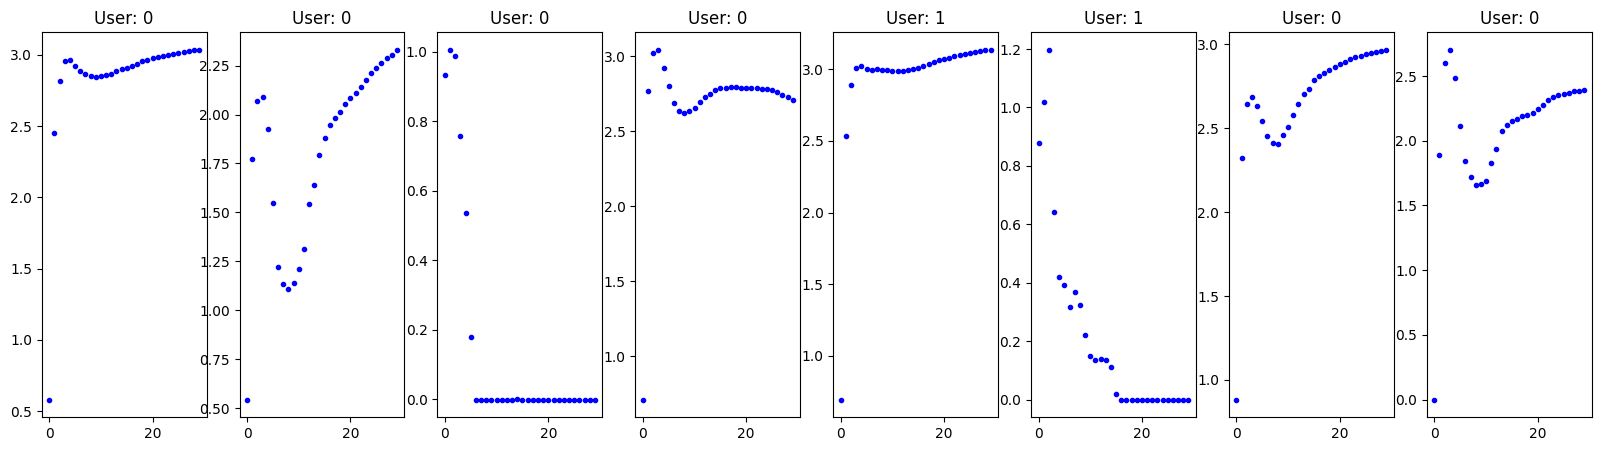

In [3]:
# Split data into test  and train set
Xtrain, Xtest, ytrain, ytest = train_test_split(Xraw, yraw, test_size=0.15, random_state=42)
print("Size of test set:", Xtest.shape)
print("Size of train set:", Xtrain.shape)
print("Fraction of single class in test set: ", np.mean(ytest==0))

# Plot the first 8 cases from train test
import matplotlib.pyplot as plt
nplots = 8
plt.figure(figsize=(20, 5))
for i in range(nplots):
    plt.subplot(1, nplots, i+1)
    plt.plot(range(len(Xtrain[i])), Xtrain[i], "b.")
    plt.title(f"User: {ytrain[i]}")

In [4]:
# The normalization should always be relative to the train set but I this simple norm is okay for nowk 
# Skip this cell to try unormalised data
def normalize(x):   
    # Use quantities from training data set
    avgmax = np.max(x, axis=1)[:, np.newaxis]
    return x / avgmax 

Xtrain = normalize(Xtrain) 
Xtest = normalize(Xtest)

In [5]:
# Try to code a simple network
import torch

device = torch.device('cpu')
dtype = torch.float32

# Function to print accuracy of validation set while training
def checkAcc(x, y, model, set="Train set"):
    scores = model(x)
    _, preds = scores.max(1)    # Returns indices alongside axis=1
    num_correct = (preds == y).sum()
    num_samples = preds.size(0)
    acc = float(num_correct) / num_samples
    print(f"{set} Accuracy: {num_correct} / {num_samples} = {acc:.2f}")

# Define a general procedure to train a model
def trainModel(model, loss_fn, optimizer, x, y, N=1000):
    for t in range(N):

        y_pred = model(x)

        loss = loss_fn(y_pred, y)

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # Internally, this call will compute gradients for all learnable parameters in the model.
        loss.backward()

        # Update weights
        optimizer.step()
        # Zero the gradients after weight updates.
        optimizer.zero_grad()

        with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
            if t%100==0:
                print(f"Iteration {t}\nLoss: {loss.item()}")
                checkAcc(x, y, model)

In [6]:
# Pass data to tensors
x = torch.tensor(Xtrain, device=device, dtype=dtype)
y = torch.tensor(ytrain, device=device, dtype=torch.long)

xt= torch.tensor(Xtest, device=device, dtype=dtype)
yt= torch.tensor(ytest, device=device, dtype=torch.long)

In [7]:
# Simple Fully Connected NN
# Gets 0.7 accuracy after 10000 iterations, but performs better with unormalised parameters (0.8)
N, D_in, H, D_out = len(Xtrain), 30, 1000, 2 

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        ).to(device)

# Loss function to use - check available functions on pytorch
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

trainModel(model, loss_fn, optimizer, x, y, 10000)
# Test model on test data
with torch.no_grad():
    checkAcc(xt, yt, model, set="\nTest")

Iteration 0
Loss: 0.7349217534065247
Train set Accuracy: 73 / 150 = 0.49
Iteration 100
Loss: 0.7002573013305664
Train set Accuracy: 71 / 150 = 0.47
Iteration 200
Loss: 0.6919083595275879
Train set Accuracy: 73 / 150 = 0.49
Iteration 300
Loss: 0.6896368265151978
Train set Accuracy: 92 / 150 = 0.61
Iteration 400
Loss: 0.6887280344963074
Train set Accuracy: 78 / 150 = 0.52
Iteration 500
Loss: 0.6881227493286133
Train set Accuracy: 78 / 150 = 0.52
Iteration 600
Loss: 0.6875868439674377
Train set Accuracy: 78 / 150 = 0.52
Iteration 700
Loss: 0.6870691776275635
Train set Accuracy: 78 / 150 = 0.52
Iteration 800
Loss: 0.6865580081939697
Train set Accuracy: 78 / 150 = 0.52
Iteration 900
Loss: 0.686049222946167
Train set Accuracy: 78 / 150 = 0.52
Iteration 1000
Loss: 0.6855419874191284
Train set Accuracy: 78 / 150 = 0.52
Iteration 1100
Loss: 0.6850374937057495
Train set Accuracy: 77 / 150 = 0.51
Iteration 1200
Loss: 0.6845356822013855
Train set Accuracy: 77 / 150 = 0.51
Iteration 1300
Loss: 0.68

In [8]:
# To tun convolutions, need to modify shape of input
x = x.view(x.shape[0], 1, x.shape[1])
xt = xt.view(xt.shape[0], 1, xt.shape[1])

In [9]:
# NN with 2 Convolution Layers
# Performs best with normalised data, but still works with unormalised

class deepModel(torch.nn.Module):
    def __init__(self):
        super(deepModel, self).__init__()

        # Number of filters on each layer
        D1 = 12 
        D2 = 12 

        self.layer1 = torch.nn.Sequential(
                torch.nn.Conv1d(1, D1, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=2)
                )
        
        self.layer2 = torch.nn.Sequential(
                torch.nn.Conv1d(D1, D2, kernel_size=3, padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(kernel_size=3)
                )
        # self.drop_out = torch.nn.Dropout()
        self.fc1 = torch.nn.Linear(D2 * 5, 100)    
        self.fc2 = torch.nn.Linear(100, 2)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.shape[0], -1)   # Flatten tensor
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model_deep = deepModel().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optim_deep = torch.optim.SGD(model_deep.parameters(), lr=1e-3, momentum=0.9)

trainModel(model_deep, loss_fn, optim_deep, x, y, 10000)
with torch.no_grad():
    checkAcc(xt, yt, model_deep, set="\nTest")

Iteration 0
Loss: 0.6984320282936096
Train set Accuracy: 78 / 150 = 0.52
Iteration 100
Loss: 0.6919087171554565
Train set Accuracy: 78 / 150 = 0.52
Iteration 200
Loss: 0.6915891766548157
Train set Accuracy: 78 / 150 = 0.52
Iteration 300
Loss: 0.6913021802902222
Train set Accuracy: 78 / 150 = 0.52
Iteration 400
Loss: 0.6910012364387512
Train set Accuracy: 78 / 150 = 0.52
Iteration 500
Loss: 0.6906737089157104
Train set Accuracy: 78 / 150 = 0.52
Iteration 600
Loss: 0.6903074383735657
Train set Accuracy: 78 / 150 = 0.52
Iteration 700
Loss: 0.68988436460495
Train set Accuracy: 78 / 150 = 0.52
Iteration 800
Loss: 0.6893829107284546
Train set Accuracy: 78 / 150 = 0.52
Iteration 900
Loss: 0.688796877861023
Train set Accuracy: 78 / 150 = 0.52
Iteration 1000
Loss: 0.6880459785461426
Train set Accuracy: 78 / 150 = 0.52
Iteration 1100
Loss: 0.6872350573539734
Train set Accuracy: 78 / 150 = 0.52
Iteration 1200
Loss: 0.6863776445388794
Train set Accuracy: 78 / 150 = 0.52
Iteration 1300
Loss: 0.6854

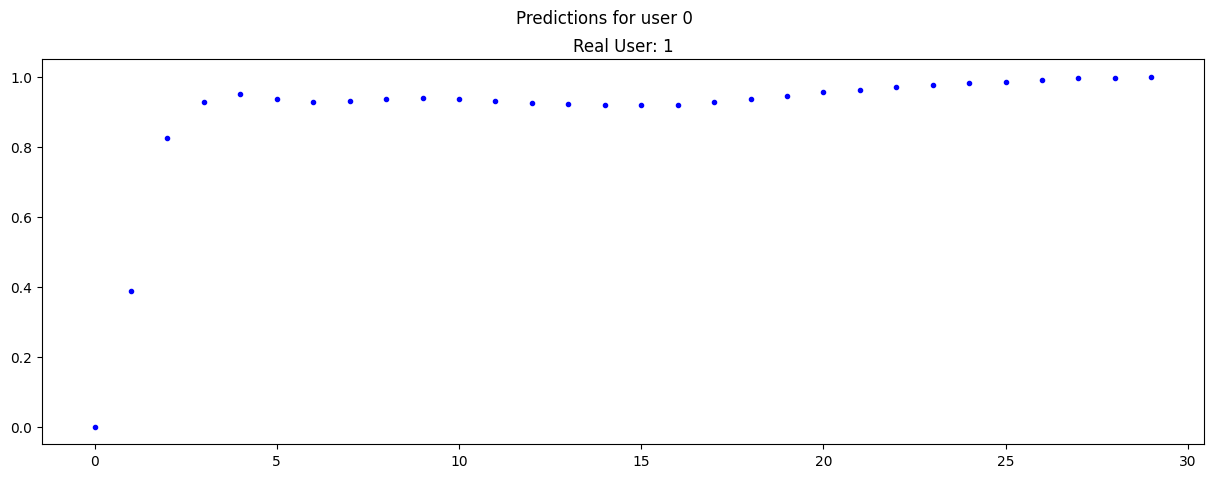

<Figure size 1500x500 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

def plotTest(Xtest, ytest, predictions, misclassifications_only=True):

    usr1 = (predictions==0) 
    usr2 = (predictions==1)
    
    if misclassifications_only:
        usr1 = (predictions==0) & (ytest==1)
        usr2 = (predictions==1) & (ytest==0) 

    for j, usr in enumerate([usr1, usr2]):
        X1 = Xtest[usr]
        labels = ytest[usr]
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Predictions for user {j}")
        for i, (x, lab) in enumerate(zip(X1, labels)):
            plt.subplot(1, len(X1), i+1)
            plt.plot(range(len(x)), x, "b.")
            plt.title(f"Real User: {lab}")


# Plot results
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model_deep(xt)
    _, preds = scores.max(1)
    predictions = preds.detach().numpy()

plotTest(Xtest, ytest, predictions)
# plt.show()

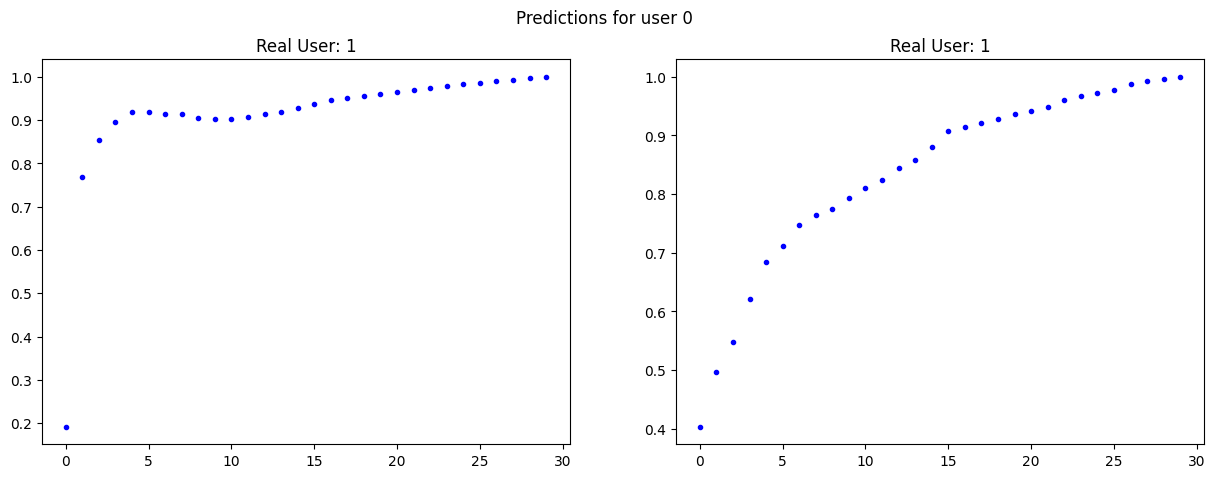

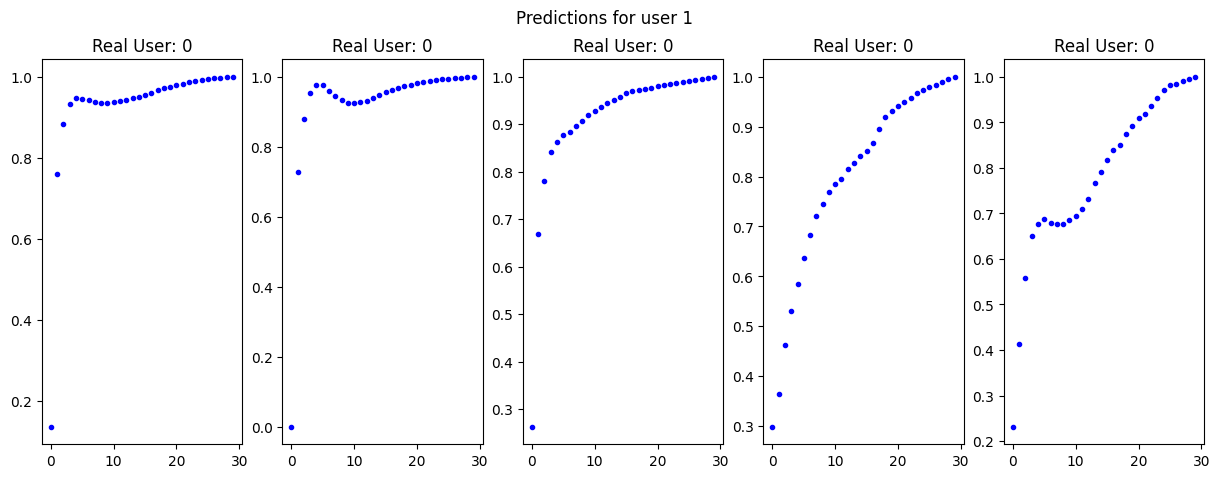

In [11]:
# Plot misclassifications from training
with torch.no_grad():     # Very important to specify no_grad to avoid automatic differentiation of this step
    scores = model_deep(x)
    _, preds = scores.max(1)
    predictions = preds.detach().numpy()

plotTest(Xtrain, ytrain, predictions)